# First look into the King County Washington data

In [1]:
# import packages from Matt's Code Challege solution, this will be updated later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup
import requests
import json
from shapely.geometry import Point, Polygon
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [2]:
# Pulling in first data set
path = "../../../data/kc_house_data.csv"
df = pd.read_csv(path)
df.drop_duplicates(subset="id", inplace=True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Checking what is in this data set
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   date           21420 non-null  object 
 2   price          21420 non-null  float64
 3   bedrooms       21420 non-null  int64  
 4   bathrooms      21420 non-null  float64
 5   sqft_living    21420 non-null  int64  
 6   sqft_lot       21420 non-null  int64  
 7   floors         21420 non-null  float64
 8   waterfront     19067 non-null  float64
 9   view           21357 non-null  float64
 10  condition      21420 non-null  int64  
 11  grade          21420 non-null  int64  
 12  sqft_above     21420 non-null  int64  
 13  sqft_basement  21420 non-null  object 
 14  yr_built       21420 non-null  int64  
 15  yr_renovated   17616 non-null  float64
 16  zipcode        21420 non-null  int64  
 17  lat            21420 non-null  float64
 18  long  

## Feature Engineering School District's by State ranking

### Webscraping a School District ranking into a useful Pandas Dataframe

In [4]:
url = 'https://backgroundchecks.org/top-school-districts-in-washington-2018.html'
response = requests.get(url,timeout=30)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find_all('table')
df_school = pd.read_html(str(table))[0]

In [5]:
df_school["School District"]=df_school["School District"].str.replace(" School District","").copy()

In [6]:
df_school.drop(columns=("State"),inplace=True)

In [7]:
df_school.head(20)

,State Rank,School District
0,1,Mercer Island
1,2,Lake Washington
2,3,Snoqualmie Valley
3,4,Bellevue
4,5,Camas
5,6,Issaquah
6,7,Bainbridge Island
7,8,Northshore
8,9,Tahoma
9,10,Tumwater


### GeoAPI for coordinates data to determine school district by coordinates in the original Data

In [8]:
url = 'https://opendata.arcgis.com/datasets/bace62518e9e4b5fbd6dfc386380d417_416.geojson'
school_data = requests.get(url,timeout=5)

In [9]:
# Good connection for 200
print(school_data)

<Response [200]>


In [10]:
# Pulling out the School districts in King County
district_api = school_data.json()
School_districts=[]
for i in range(0, len(district_api["features"])):
    School_districts.append(district_api["features"][i]['properties']["NAME"])
print(School_districts)

['Seattle', 'Federal Way', 'Enumclaw', 'Mercer Island', 'Highline', 'Vashon Island', 'Renton', 'Skykomish', 'Bellevue', 'Tukwila', 'Riverview', 'Auburn', 'Tahoma', 'Snoqualmie Valley', 'Issaquah', 'Shoreline', 'Lake Washington', 'Kent', 'Northshore', 'Fife']


In [11]:
# convert longitude and latitude to coordinates
df["Coordinates"]=list(zip(df["long"],df["lat"]))

In [12]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Coordinates
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,"(-122.257, 47.5112)"
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,"(-122.319, 47.721000000000004)"
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,"(-122.23299999999999, 47.7379)"
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,"(-122.39299999999999, 47.5208)"
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,"(-122.045, 47.6168)"


#### Using Shapely Polygons to programmatically map houses are a school district

In [13]:
Shape1 = Polygon(district_api["features"][0]["geometry"]["coordinates"][0][0])

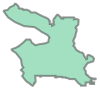

In [14]:
Shape1

In [15]:
Shape2 = Polygon(district_api["features"][0]["geometry"]["coordinates"][1][0])

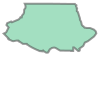

In [16]:
Shape2

In [17]:
geometry = district_api["features"][0]["geometry"]["coordinates"]

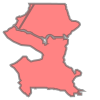

In [18]:
Polygon(geometry[0][0]+geometry[1][0])

In [19]:
fix1=district_api["features"][0]["geometry"]["coordinates"][0][0]+district_api["features"][0]["geometry"]["coordinates"][1][0]

In [20]:
Shape1=Polygon(fix1)

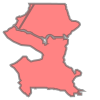

In [21]:
Shape1

In [22]:
Shape2 = Polygon(district_api["features"][2]["geometry"]["coordinates"][0])

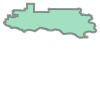

In [23]:
Shape2

In [24]:
#Heavy lifting for this feature, creates Polygons out of the coordinate locations provided in the json api.
school_district_shapes=[]
for district in district_api["features"]:
    d={}
    d["name"]=district['properties']["NAME"]
    geometry = district["geometry"]["coordinates"]
    if len(geometry) != 1:
        d["shape"]=Polygon(geometry[0][0]+geometry[1][0])
    else:
        d["shape"]=Polygon(geometry[0])
    school_district_shapes.append(d)

In [25]:
school_district_shapes[0]["shape"].contains(Point(df["Coordinates"][21579])) 

True

In [26]:
# Merging the original Dataframe with the API by checking each house's coordinate
SD = []
for sold_data_point in df["Coordinates"]:
    for shape in school_district_shapes:
        if shape["shape"].contains(Point(sold_data_point)):
            SD.append(shape["name"])    
            break

In [27]:
len(SD)

21410

In [28]:
df.shape

(21420, 22)

In [29]:
df["School District"]=pd.DataFrame({"School District":SD})

There were 186 sells that my for loop did not asign a school district too. For now I will drop them and work on ranking the schools.

In [30]:
df["School District"].isna().sum()

186

In [31]:
df.dropna(subset=["School District"], inplace=True)

In [32]:
df_school["School District"]=df_school["School District"].apply(lambda x:x.lower().replace("^a-z",''))

In [33]:
df_school.replace({"School District":{"seattle public schools":"seattle"}}, inplace=True)

In [34]:
df_school["School District"].unique()

array(['mercer island', 'lake washington', 'snoqualmie valley',
       'bellevue', 'camas', 'issaquah', 'bainbridge island', 'northshore',
       'tahoma', 'tumwater', 'ridgefield', 'shoreline', 'anacortes',
       'university place', 'lake stevens', 'hockinson', 'seattle',
       'everett', 'olympia', 'pullman', 'peninsula', 'mead', 'arlington',
       'rochester', 'bellingham', 'riverview', 'puyallup', 'orcas island',
       'cascade', 'steilacoom hist.', 'north kitsap', 'colfax', 'edmonds',
       'nooksack valley', 'sumner', 'richland', 'vashon island',
       'stanwood-camano', 'central valley', 'napavine', 'lynden',
       'snohomish', 'mukilteo', 'monroe', 'white river',
       'west valley (yakima)', 'yelm', 'sultan', 'kent', 'reardan-edwall',
       'asotin-anatone', 'port angeles', 'evergreen (clark)', 'meridian',
       'wilbur', 'north thurston public schools', 'ferndale',
       'south kitsap', 'san juan island', 'cheney', 'la center',
       'enumclaw', 'chehalis', 'washo

In [35]:
df["School District"]=df["School District"].apply(lambda x:x.lower().replace("^a-z",''))

In [36]:
df["School District"].unique()

array(['seattle', 'northshore', 'lake washington', 'federal way',
       'highline', 'tahoma', 'bellevue', 'riverview', 'auburn',
       'mercer island', 'kent', 'issaquah', 'renton', 'vashon island',
       'snoqualmie valley', 'shoreline', 'enumclaw', 'tukwila', 'fife',
       'skykomish'], dtype=object)

In [37]:
df_rank = df.merge(df_school, on="School District",how='left')

In [38]:
# Replaced any school district's that were unranked were set to 101
df_rank["State Rank"].fillna(101,inplace=True)

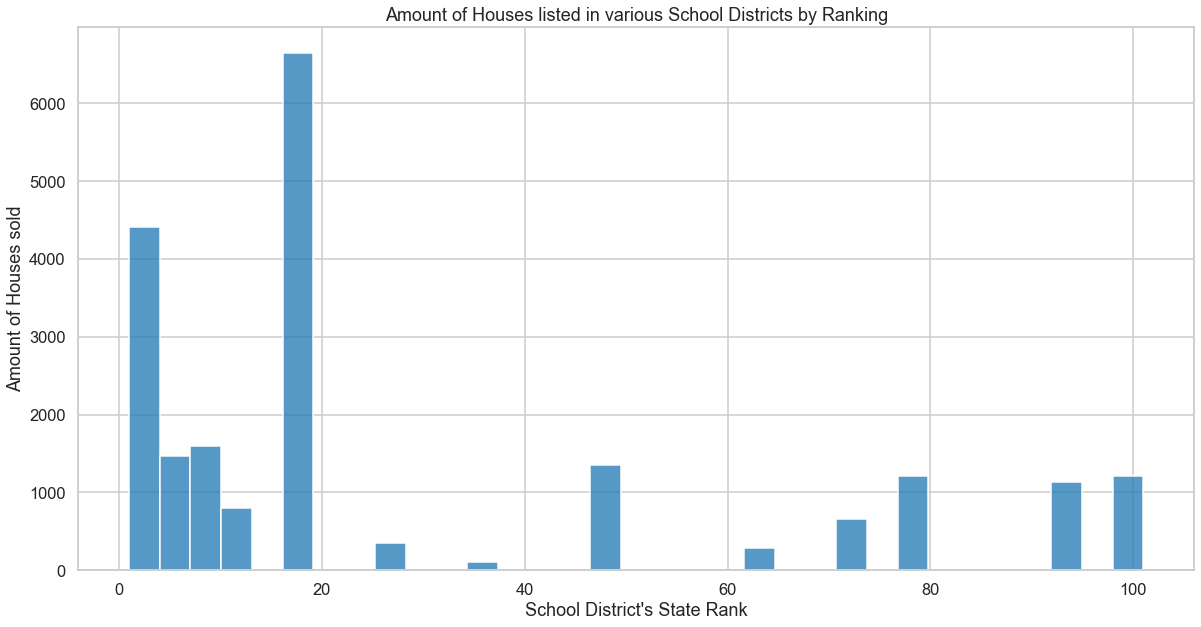

In [55]:
fig, ax = plt.subplots(figsize = (20,10))
State_Ranks_per_cost=sns.histplot(df_rank["State Rank"])
State_Ranks_per_cost.set(title="Amount of Houses listed in various School Districts by Ranking", xlabel="School District's State Rank", ylabel="Amount of Houses sold");
# plt.savefig('Amount of Houses listed in various School Districts by Ranking.png', dpi=300)

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [41]:
df_rank.sort_values(["price"],ascending=False).head(20)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Coordinates,School District,State Rank
7187,6762700020,10/13/2014,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,...,1910,1987.0,98102,47.6298,-122.323,3940,8800,"(-122.323, 47.6298)",seattle,17.0
3877,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,1.0,2.0,...,1940,2001.0,98004,47.6500,-122.214,3930,25449,"(-122.214, 47.65)",renton,79.0
9170,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,0.0,4.0,...,2001,0.0,98039,47.6305,-122.240,4540,42730,"(-122.24, 47.6305)",seattle,17.0
4371,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,0.0,0.0,...,2001,NaN,98039,47.6289,-122.233,3560,24345,"(-122.23299999999999, 47.6289)",seattle,17.0
1434,8907500070,4/13/2015,5350000.0,5,5.00,8000,23985,2.0,0.0,4.0,...,2009,0.0,98004,47.6232,-122.220,4600,21750,"(-122.22, 47.6232)",federal way,93.0
1301,7558700030,4/13/2015,5300000.0,6,6.00,7390,24829,2.0,1.0,NaN,...,1991,0.0,98040,47.5631,-122.210,4320,24619,"(-122.21, 47.5631)",seattle,17.0
1152,1247600105,10/20/2014,5110000.0,5,5.25,8010,45517,2.0,1.0,4.0,...,1999,0.0,98033,47.6767,-122.211,3430,26788,"(-122.211, 47.6767)",seattle,17.0
8023,1924059029,6/17/2014,4670000.0,5,6.75,9640,13068,1.0,1.0,4.0,...,1983,2009.0,98040,47.5570,-122.210,3270,10454,"(-122.21, 47.556999999999995)",kent,49.0
2601,7738500731,8/15/2014,4500000.0,5,5.50,6640,40014,2.0,1.0,4.0,...,2004,0.0,98155,47.7493,-122.280,3030,23408,"(-122.28, 47.7493)",lake washington,2.0
8560,3835500195,6/18/2014,4490000.0,4,3.00,6430,27517,2.0,0.0,0.0,...,2001,0.0,98004,47.6208,-122.219,3720,14592,"(-122.219, 47.6208)",seattle,17.0


In [42]:
df_rank["State Rank"]=df_rank["State Rank"].astype(int)

In [43]:
df_backup=df_rank[["State Rank", "School District"]]

In [44]:
School_Districts_used=set(zip(df_backup["State Rank"].unique(),df_backup["School District"].apply(lambda x:x.title()).unique()))
School_Districts_used

{(1, 'Mercer Island'),
 (2, 'Lake Washington'),
 (3, 'Snoqualmie Valley'),
 (4, 'Bellevue'),
 (6, 'Issaquah'),
 (8, 'Northshore'),
 (9, 'Tahoma'),
 (12, 'Shoreline'),
 (17, 'Seattle'),
 (26, 'Riverview'),
 (37, 'Vashon Island'),
 (49, 'Kent'),
 (62, 'Enumclaw'),
 (73, 'Auburn'),
 (79, 'Renton'),
 (93, 'Federal Way'),
 (101, 'Highline')}

In [45]:
X=df_rank[["State Rank"]]
y=df_rank["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [46]:
X_test.to_numpy().reshape(1,-1)

array([[17, 17,  9, ..., 17,  2,  6]])

In [47]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)

In [48]:
X_train

array([[11.],
       [ 4.],
       [ 1.],
       ...,
       [ 2.],
       [ 1.],
       [ 8.]])

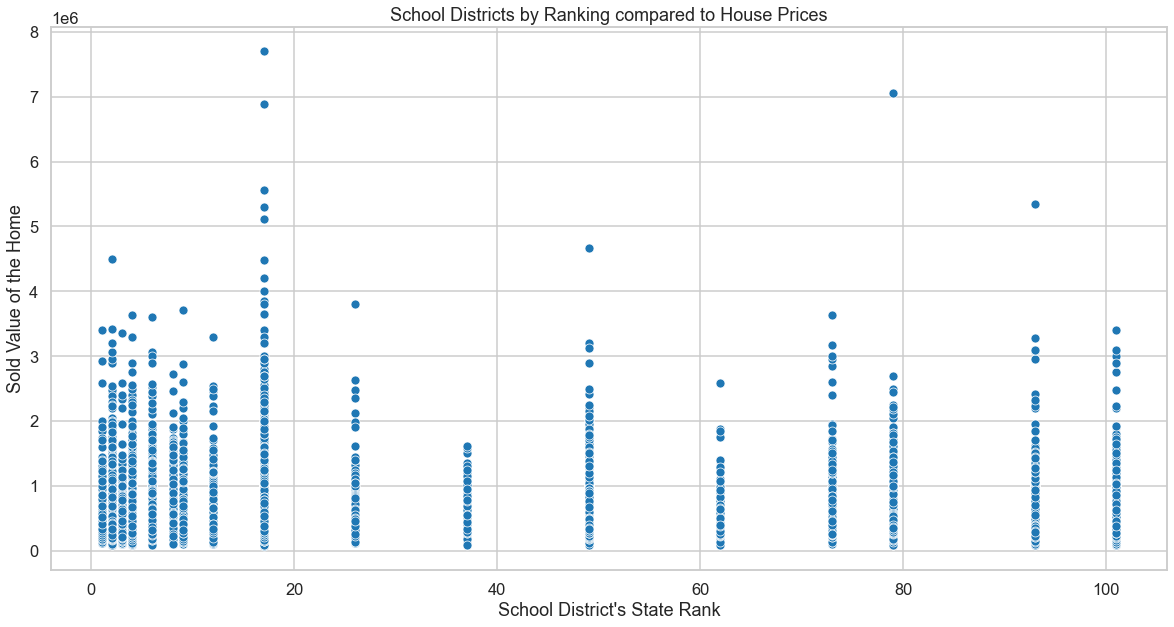

In [56]:
fig, ax = plt.subplots(figsize = (20,10))
Confirming_categorical_data=sns.scatterplot(x=df_rank["State Rank"],y=df_rank["price"])
Confirming_categorical_data.set(title="School Districts by Ranking compared to House Prices", xlabel="School District's State Rank", ylabel="Sold Value of the Home");
# plt.savefig('School Districts by Ranking compared to House Prices.png', dpi=300)

### Binning various columns to work better in preditive models.

In [78]:
df_rank.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'Coordinates',
       'School District', 'State Rank'],
      dtype='object')

In [81]:
df_rank['condition'].unique()

array(['good', 'very_good', 'bad'], dtype=object)

In [80]:
# Changing condition to bins of bad, good, very good

for i in range (0, len(df_rank)):
    if df_rank['condition'].iloc[i] == 1:
        df_rank['condition'].iloc[i] = "bad"
    elif df_rank['condition'].iloc[i] == 2:
        df_rank['condition'].iloc[i] = "bad"
    elif df_rank['condition'].iloc[i] == 3:
        df_rank['condition'].iloc[i] = "good"
    elif df_rank['condition'].iloc[i] == 4:
        df_rank['condition'].iloc[i] = "very_good"
    elif df_rank['condition'].iloc[i] == 5:
        df_rank['condition'].iloc[i] = "very_good"

C:\Users\Catherine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [85]:
df_rank['grade'].unique()

array(['good', 'bad', 'very_good'], dtype=object)

In [84]:
# Changing grade to bins of bad, good, very good
for i in range (0, len(df_rank)):
    if df_rank['grade'].iloc[i] == 3:
        df_rank['grade'].iloc[i] = "bad"
    elif df_rank['grade'].iloc[i] == 4:
        df_rank['grade'].iloc[i] = "bad"
    elif df_rank['grade'].iloc[i] == 5:
        df_rank['grade'].iloc[i] = "bad"
    elif df_rank['grade'].iloc[i] == 6:
        df_rank['grade'].iloc[i] = "bad"
    elif df_rank['grade'].iloc[i] == 7:
        df_rank['grade'].iloc[i] = "good"
    elif df_rank['grade'].iloc[i] == 8:
        df_rank['grade'].iloc[i] = "good"
    elif df_rank['grade'].iloc[i] == 9:
        df_rank['grade'].iloc[i] = "good"
    elif df_rank['grade'].iloc[i] == 10:
        df_rank['grade'].iloc[i] = 'very_good'
    elif df_rank['grade'].iloc[i] == 11:
        df_rank['grade'].iloc[i] = 'very_good'
    elif df_rank['grade'].iloc[i] == 12:
        df_rank['grade'].iloc[i] = 'very_good'
    elif df_rank['grade'].iloc[i] == 13:
        df_rank['grade'].iloc[i] = 'very_good'

In [87]:
df_rank['bathrooms'].unique()

array(['minimal', 'average', 'many'], dtype=object)

In [86]:
# Changing bathrooms to minimal, average, many
for i in range (0, len(df_rank)):
    if df_rank["bathrooms"].iloc[i] == 0.5:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 0.75:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 1:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 1.25:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 1.5:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 1.75:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 2.0:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 2.25:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 2.5:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 2.75:
        df_rank["bathrooms"].iloc[i] = "minimal"
    elif df_rank["bathrooms"].iloc[i] == 3.0:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 3.25:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 3.5:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 3.75:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 4.0:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 4.25:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 4.5:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 4.75:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 5.0:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 5.25:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 5.5:
        df_rank["bathrooms"].iloc[i] = "average"
    elif df_rank["bathrooms"].iloc[i] == 5.75:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 6.0:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 6.25:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 6.5:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 6.75:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 7.5:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 7.75:
        df_rank["bathrooms"].iloc[i] = "many"
    elif df_rank["bathrooms"].iloc[i] == 8.0:
        df_rank["bathrooms"].iloc[i] = "many"

In [89]:
set(df_rank['bedrooms'].unique())

{'excessive', 'moderate', 'small'}

In [88]:
# Changing
for i in range (0, len(df_rank)):
    if df_rank['bedrooms'].iloc[i] == 1:
        df_rank['bedrooms'].iloc[i] = "small"
    elif df_rank['bedrooms'].iloc[i] == 2:
        df_rank['bedrooms'].iloc[i] = "small"
    elif df_rank['bedrooms'].iloc[i] == 3:
        df_rank['bedrooms'].iloc[i] = "small"
    elif df_rank['bedrooms'].iloc[i] == 4:
        df_rank['bedrooms'].iloc[i] = "small"
    elif df_rank['bedrooms'].iloc[i] == 5:
        df_rank['bedrooms'].iloc[i] = "moderate"
    elif df_rank['bedrooms'].iloc[i] == 6:
        df_rank['bedrooms'].iloc[i] = "moderate"
    elif df_rank['bedrooms'].iloc[i] == 7:
        df_rank['bedrooms'].iloc[i] = "moderate"
    elif df_rank['bedrooms'].iloc[i] == 8:
        df_rank['bedrooms'].iloc[i] = 'moderate'
    elif df_rank['bedrooms'].iloc[i] == 9:
        df_rank['bedrooms'].iloc[i] = 'excessive'
    elif df_rank['bedrooms'].iloc[i] == 10:
        df_rank['bedrooms'].iloc[i] = 'excessive'
    elif df_rank['bedrooms'].iloc[i] == 11:
        df_rank['bedrooms'].iloc[i] = 'excessive'
    elif df_rank['bedrooms'].iloc[i] == 33:
        df_rank['bedrooms'].iloc[i] = 'excessive'

In [95]:
(df_rank['State Rank'].unique())

array(['11-50', 'Top_ten', '51-above'], dtype=object)

In [94]:
# Changing bathrooms to Top_ten, 11-50, 51-above
for i in range (0, len(df_rank)):
    if df_rank['State Rank'].iloc[i] == 1:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 2:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 3:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 3:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 4:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 6:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 8:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 9:
        df_rank['State Rank'].iloc[i] = "Top_ten"
    elif df_rank['State Rank'].iloc[i] == 12:
        df_rank['State Rank'].iloc[i] = "11-50"
    elif df_rank['State Rank'].iloc[i] == 17:
        df_rank['State Rank'].iloc[i] = "11-50"
    elif df_rank['State Rank'].iloc[i] == 26:
        df_rank['State Rank'].iloc[i] = "11-50"
    elif df_rank['State Rank'].iloc[i] == 37:
        df_rank['State Rank'].iloc[i] = "11-50"
    elif df_rank['State Rank'].iloc[i] == 49:
        df_rank['State Rank'].iloc[i] = "11-50"
    elif df_rank['State Rank'].iloc[i] == 62:
        df_rank['State Rank'].iloc[i] = "51-above"
    elif df_rank['State Rank'].iloc[i] == 73:
        df_rank['State Rank'].iloc[i] = "51-above"
    elif df_rank['State Rank'].iloc[i] == 79:
        df_rank['State Rank'].iloc[i] = "51-above"
    elif df_rank['State Rank'].iloc[i] == 93:
        df_rank['State Rank'].iloc[i] = "51-above"
    elif df_rank['State Rank'].iloc[i] == 101:
        df_rank['State Rank'].iloc[i] = "51-above"

In [96]:
df_rank.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Coordinates,School District,State Rank
0,7129300520,10/13/2014,221900.0,small,minimal,1180,5650,1.0,NaN,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,"(-122.257, 47.5112)",seattle,11-50
1,6414100192,12/9/2014,538000.0,small,minimal,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,"(-122.319, 47.721000000000004)",seattle,11-50
2,5631500400,2/25/2015,180000.0,small,minimal,770,10000,1.0,0.0,0.0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,"(-122.23299999999999, 47.7379)",northshore,Top_ten
3,2487200875,12/9/2014,604000.0,small,average,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,"(-122.39299999999999, 47.5208)",seattle,11-50
4,1954400510,2/18/2015,510000.0,small,minimal,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,"(-122.045, 47.6168)",lake washington,Top_ten


In [97]:
model_df=df_rank.copy()

#### Created csv file for Hayden's models to run off of

In [99]:
# model_df.to_csv("Df with State Rank plus binned columns.csv")